Solved in 19 trials!


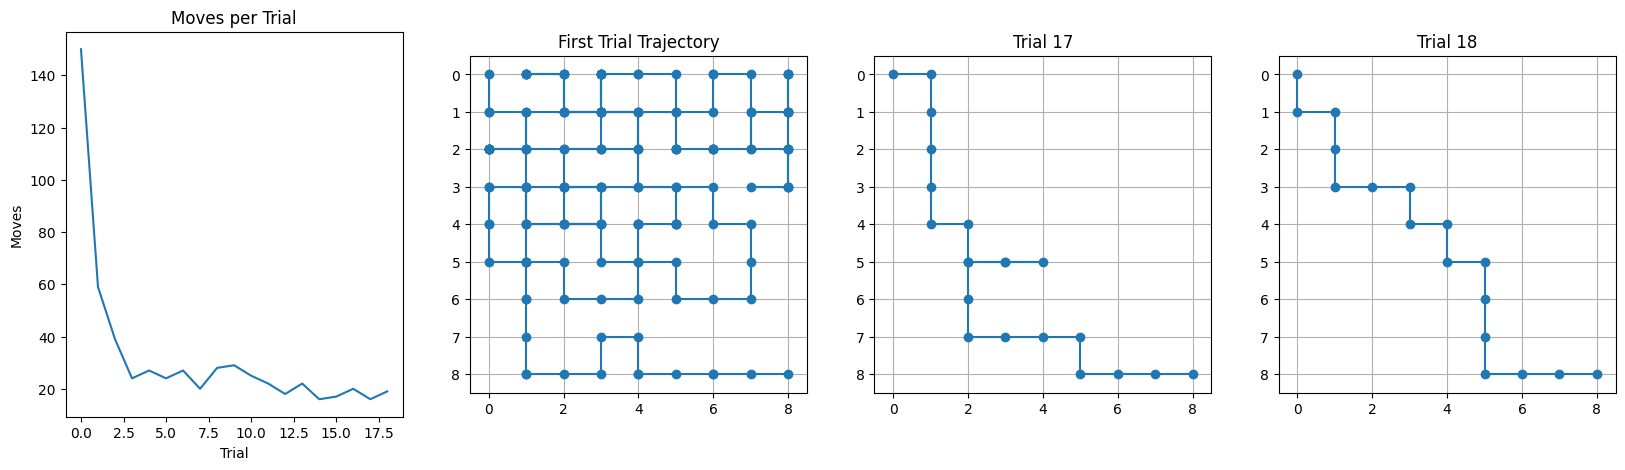

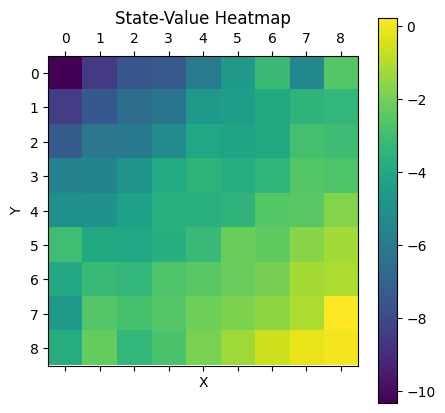

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import random

# ─── Parameters ────────────────────────────────────────────────────────────────
grid_size       = 9
num_states      = grid_size * grid_size
actions         = ['left', 'right', 'up', 'down']
alpha           = 0.1  # learning rate
gamma           = 0.99 # discount factor
epsilon         = 0.1     # ε‐greedy rate
tau             = 1.0     # softmax temperature
use_softmax     = False # if True, use softmax policy instead of ε‐greedy
max_trials      = 1000000
criterion_moves = grid_size*2+2      # “success” threshold: <= this many moves
min_successes   = 5       # # of consecutive successes to stop
use_lambda = True# set False to revert to TD(0)
lambda_    = 0.9    # trace decay
# ────────────────────────────────────────────────────────────────────────────────

# State‐↔‐grid helper
def state_to_pos(s): return divmod(s, grid_size)
def pos_to_state(r,c): return r * grid_size + c

# Given state and action, return next state (no “stay” action)
def take_action(s, a):
    r, c = state_to_pos(s)
    if a=='left':  c = max(0, c-1)
    if a=='right': c = min(grid_size-1, c+1)
    if a=='up':    r = max(0, r-1)
    if a=='down':  r = min(grid_size-1, r+1)
    return pos_to_state(r,c)

# ε‐greedy over next‐state values
def select_action_eps(state, V):
    # compute values of all next states
    next_states = [take_action(state,a) for a in actions]
    if random.random() < epsilon:
        return random.randrange(len(actions))
    else:
        vals = [V[s_] for s_ in next_states]
        return int(np.argmax(vals))

# softmax over next‐state values
def select_action_soft(state, V):
    next_states = [take_action(state,a) for a in actions]
    vals = np.array([V[s_] for s_ in next_states])
    # numerical stability
    m = vals.max()
    probs = np.exp((vals - m)/tau)
    probs /= probs.sum()
    return int(np.random.choice(len(actions), p=probs))

# ─── Initialize ────────────────────────────────────────────────────────────────
V = np.random.uniform(0, 0.01, size=num_states)  # state‐value estimates
start_state = 0
goal_state  = num_states - 1

moves_per_trial     = []
consecutive_success = 0
first_trajectory    = None
last_three_trajs    = []

# ─── Initialization ───────────────────────────────────────────────────────────
V = np.random.uniform(0,0.01, size=num_states)  # or zeros
if use_lambda:
    E = np.zeros(num_states)    # eligibility traces for states
# ──────────────────────────────────────────────────────────────────────────────

for trial in range(1, max_trials+1):
    state = start_state
    moves = 0
    traj  = [state]

    # reset eligibility at start of each episode
    if use_lambda:
        E.fill(0)

    while state != goal_state:
        # choose action (ε‐greedy or softmax over V[next_state])
        if use_softmax:
            ai = select_action_soft(state, V)
        else:
            ai = select_action_eps(state, V)

        next_state = take_action(state, actions[ai])
        reward     = 1 if next_state == goal_state else -1

        # TD error
        delta = reward + gamma * V[next_state] - V[state]

        if use_lambda:
            # accumulate trace for current state
            E[state] += 1

            # update all states
            V += alpha * delta * E

            # decay traces
            E *= gamma * lambda_
        else:
            # pure one‐step TD
            V[state] += alpha * delta

        state = next_state
        traj.append(state)
        moves += 1


    # record progress
    moves_per_trial.append(moves)
    if trial==1:
        first_trajectory = traj
    last_three_trajs.append(traj)
    if len(last_three_trajs)>3:
        last_three_trajs.pop(0)

    # check success
    if moves <= criterion_moves:
        consecutive_success += 1
    else:
        consecutive_success = 0
    if consecutive_success >= min_successes:
        print(f"Solved in {trial} trials!")
        break

# ─── Visualization ─────────────────────────────────────────────────────────────
def plot_traj(ax, trajectory, title):
    pts = [state_to_pos(s) for s in trajectory]
    xs, ys = zip(*pts)
    ax.plot(xs, ys, '-o')
    ax.set_xlim(-.5, grid_size-.5)
    ax.set_ylim(-.5, grid_size-.5)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.grid(True)

fig, axes = plt.subplots(1, 4, figsize=(20,5))
# 1) Learning curve
axes[0].plot(moves_per_trial)
axes[0].set(title='Moves per Trial', xlabel='Trial', ylabel='Moves')

# 2) First‐trial trajectory
plot_traj(axes[1], first_trajectory, 'First Trial Trajectory')

# 3–4) Last three trajectories
for i, ax in enumerate(axes[2:]):
    if i < len(last_three_trajs):
        plot_traj(ax, last_three_trajs[i], f'Trial {trial-len(last_three_trajs)+1+i}')

# 5) State‐value heatmap (inset)
fig2, ax2 = plt.subplots(figsize=(5,5))
Vmat = V.reshape((grid_size, grid_size)).T
cax = ax2.matshow(Vmat, cmap='viridis')
fig2.colorbar(cax, ax=ax2)
ax2.set(title='State-Value Heatmap', xlabel='X', ylabel='Y')
plt.show()
